# Inhaltsübersicht EDA

### 0. Datensatz laden und bereinigen mit data_preparation.py (neu machen, wenn Funktion abgeschlossen)
- kurze Beschreibung der Daten (Ursprung, Umfang)
- Funktion data_import()
- Funktion data_cleaning()

### 1. Überblick über den Datensatz
- Spaltenbeschreibung/Datentypen: Funktion overview()
- Fehlende Werte (NaN-Anteile)
- Entfernen von Variablen mit mehr als 50% fehlenden Werten

### 2. Deskriptive Statistik & Ausreißer-Handling
- describe()-Tabellen für Schadstoffe und Wetterdaten
- Stripplots zur Ausreißererkennung für alle numerischen Spalten
- Vergleich von Mean und Median und Schiefe (skew)
- Zellenweise Ersetzung durch NaN (statt Zeilenlöschung)
- Dokumentaton der Schwellenwerte und Filterlogik
- Tabelle mit Anzahl der entfernten/extremen Werte

### 3. Korrelationsanalyse
- Korrelationsmatrix (Pearson)
- Identifikation und Dokumentation der stärksten Korrelationen
- Empfehlung zur Variablenselektion (evtl. PCA)

### 4. Vorbereitung für Clustering und andere Modellierungen
- Welche Features sollen verwendet werden?
- Standardisierung / Skalierung wie?
- Ziel der Clusteranalyse formulieren


# 0. Datensatz laden

Der Datensatz enthält Messungen zur Luftqualität sowie Wetter- und Bevölkerungdaten aus den Jahren 2014-2024, aggregiert aus verschiedenen Quellen mit einem anfänglichen Gesamtumfang von ca. 14 Mio Datenpunkten (s. README.md --> Datenquellen)
Um alle Daten in einem Pandas-Dataframe bearbeiten zu können, werden zunächst die Datensätze mit der Funktion data_import() aggregiert und anschlie0end mit der Funktion data_cleaning() so bereinigt, dass z.B. redundante Spalten entfernt werden. Die Funktionen und ihre Unterfunktionen finden befinden sich im Skript data_preparation.py.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
%matplotlib inline

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("./data/cleaned_data.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,"269,997.00",0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,"124,579.00",0.10,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,"193,814.00",0.10,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,"146,631.00",0.10,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,NaN,0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Zelle löschen, wenn cleaning-Funktion das übernimmt!

df.columns

# Some redundant columns still need to be removed from df manually: Temperature, Pressure, Wind-speed

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'Pressure', 'So2',
       'Temperature', 'Wind-gust', 'Wind-speed', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [5]:
# Zelle löschen, wenn cleaning-Funktion das übernimmt!
# Drop redundant columns

df = df.drop(columns=['Temperature', 'Wind-speed', 'Pressure'])
df.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Wind-gust',
       'Dew', 'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd',
       'Pres'],
      dtype='object')

# 1. Überblick über den Datensatz

- Überblicksfunktion .overview()
- Fehlende Werte ausloten und Spalten mit < 50% Daten entfernen.
- Nach dem kompletten Entfernen aller Spalten mit < 50% Daten umfasst der Datensatz **1.695.041 Zeilen und 22 Spalten**.

In [6]:
# Function to create overview for dtypes, missing values, unique values

def overview(df):
    '''
    Erstelle einen Überblick über einige Eigenschaften der Spalten eines DataFrames.
    VARs
        df: Der zu betrachtende DataFrame
    RETURNS:
        None
    '''
    display(pd.DataFrame({'dtype': df.dtypes,
                          'total': df.count(),
                          'missing': df.isna().sum(),
                          'missing%': df.isna().mean()*100,
                          'n_uniques': df.nunique(),
                          'uniques%': df.nunique()/df.shape[0]*100,
                          'uniques': [df[col].unique() for col in df.columns]
                         }))


In [7]:
overview(df)

,dtype,total,missing,missing%,n_uniques,uniques%,uniques
Year,int64,1695041,0,0.00,12,0.00,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
Month,int64,1695041,0,0.00,12,0.00,"[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
Day,int64,1695041,0,0.00,31,0.00,"[29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
Country,object,1695041,0,0.00,95,0.01,"[AT, AU, BE, BO, BR, CA, CH, CL, CN, CO, CY, C..."
City,object,1695041,0,0.00,616,0.04,"[Graz, Innsbruck, Linz, Salzburg, Vienna, Bris..."
Latitude,float64,1692212,2829,0.17,617,0.04,"[47.06667, 47.26266, 48.30639, 47.79941, 48.20..."
Longitude,float64,1692212,2829,0.17,616,0.04,"[15.45, 11.39454, 14.28611, 13.04399, 16.37208..."
Population,float64,363474,1331567,78.56,1289,0.08,"[269997.0, 124579.0, 193814.0, 146631.0, nan, ..."
Co,float64,1063231,631810,37.27,1009,0.06,"[0.1, 1.9, 2.1, nan, 2.3, 2.0, 3.4, 5.5, 3.8, ..."
No2,float64,1408781,286260,16.89,1291,0.08,"[9.0, 25.6, 14.2, 21.1, 4.6, 0.7, nan, 6.5, 4...."


In [8]:
# Sort missing values (descending)

missing_percent = df.isna().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)

print(missing_percent_sorted)


Population   78.56
Wind-gust    54.21
Dew          40.99
Prcp         38.73
Co           37.27
So2          31.44
Wdir         31.00
Pres         29.03
Wspd         26.90
Humidity     22.90
O3           22.07
Pm10         20.17
Tmax         18.93
Tmin         18.79
Tavg         17.35
No2          16.89
Pm25         15.50
Longitude     0.17
Latitude      0.17
Month         0.00
City          0.00
Country       0.00
Day           0.00
Year          0.00
dtype: float64


In [9]:
# Remove all columns with more than 50% missing values
# Note: This removes population data entirely!

# Anzahl der Spalten vor dem Entfernen merken
original_columns = df.shape[1]

df = df.loc[:, missing_percent <= 50]

# Print what has changed
print(f"Anzahl der entfernten Spalten: {original_columns - df.shape[1]}")
removed = missing_percent[missing_percent > 50].index
print("Entfernte Spalten:", list(removed))
print("Übrige Spalten:", df.columns)

df.head()

Anzahl der entfernten Spalten: 2
Entfernte Spalten: ['Population', 'Wind-gust']
Übrige Spalten: Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')


,Year,Month,Day,Country,City,Latitude,Longitude,Co,No2,O3,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,0.10,9.00,NaN,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,0.10,25.60,NaN,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,0.10,14.20,NaN,...,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,0.10,21.10,NaN,...,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,0.10,9.00,NaN,...,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.shape

(1695041, 22)

# Deskriptive Statistik

Es werden alle Variablen zu Schadstoffen und Wetterbedingungen nacheinander betrachtet und ggf. um Ausreißer bereiningt.
Die Visualisierung der Verteilung/Varianz erfolgt durch Stripplots. Diese eignen sich besonders gut, um Platzhalterwerte und Unregermäßigkeiten in der Verteilung augenfällig zu machen.
Entscheidungen zum Cutoff für Ausreißer werden auf der Grundlage von Weltwissen, kombiniert mit folgenden Kennzahlen getroffen:
- Mean
- Median
- Schiefe
- Min
- Max

Die Entscheidungen sind also nicht rein statistisch begründet.
Ziel der Ausreißerentfernung ist es, sachlich unmögliche Werte zu entfernen, die natürliche Varianz zu erhalten und einen repräsentativen Datensatz für folgende Modellierungen zu schaffen.

Methode zur Ausreißerentfernung: Zur Datenbereinigung wurden extreme Ausreißer in den Schadstoffwerten nicht durch das Entfernen ganzer Zeilen, sondern durch das gezielte Ersetzen der jeweiligen Zellen mit NaN behandelt. So bleiben andere valide Messwerte in der gleichen Zeile erhalten.

Zum Vorgehen: Zunächst werden die Schadstoffe einer nach dem anderen betrachtet. Im Anschluss werden alle Wettervariablen in einer gemeinsamen Schleife visualisiert, die Ausreißer entfernt und die Ergebnisse diskutiert und dokumentiert.

# Analyse der Schadstoffdaten

In [11]:
# Pollutants

pollutant_cols = ["Co", "Pm25", "Pm10", "So2", "No2", "O3"]
df[pollutant_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Co,"1,063,231.00",4.77,8.89,0.00,1.40,3.40,5.60,500.00
Pm25,"1,432,252.00",53.25,41.04,0.00,25.00,42.00,67.00,999.00
Pm10,"1,353,189.00",27.07,27.69,0.00,12.00,19.00,34.00,999.00
So2,"1,162,066.00",3.98,8.82,0.00,1.20,2.50,4.30,500.00
No2,"1,408,781.00",9.76,10.50,0.00,4.60,7.50,12.40,500.00
O3,"1,320,893.00",20.46,15.39,0.00,11.80,19.90,27.20,500.00


Die Messwerte, die als Maxima angegeben sind (Co = 500 oder Pm25 = 999) lassen Platzhalter für fehlende oder ungültige Daten vermuten. Solche Werte können die Verteilung erheblich verzerren und sollten im Folgenden genau in Augenschein genommen werden.

Damit die Anzahl der entfernten Ausreißer ermittelt werden kann, muss vor der Aureißerentfernung deren Anzahl ermittelt und gespeichert werden:

In [12]:
# Vor der Bereinigung: fehlende Werte zählen
missing_before = df.isna().sum()

# Gesamtgröße des df speichern, um später den Prozentsatz an durch Ausreißerentfernung verlorenen Werten zu berechnen
total_values_before = df.shape[0] * df.shape[1]

## Mittelgroße Feinstaubpartikel (Pm25)

"Die als Feinstaub (PM2,5) bezeichnete Staubfraktion enthält 50% der Teilchen mit einem Durchmesser von 2,5 µm, einen höheren Anteil kleinerer Teilchen und einen niedrigeren Anteil größerer Teilchen." (https://www.umweltbundesamt.at/umweltthemen/luft/luftschadstoffe/staub/pm25)


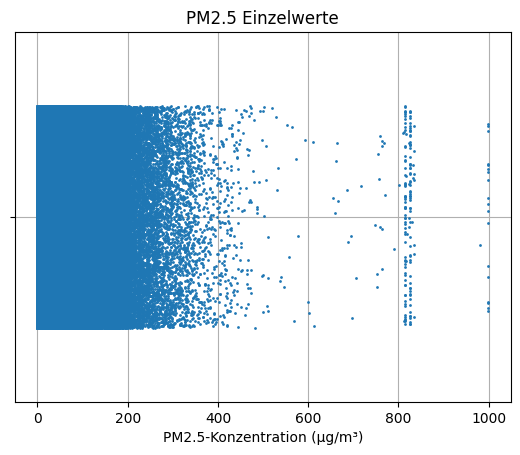

In [13]:
sns.stripplot(x=df["Pm25"], size=2, jitter=0.3)
plt.title("PM2.5 Einzelwerte")
plt.xlabel("PM2.5-Konzentration (µg/m³)")
plt.grid(True);

Bei der visuellen Analyse der PM2.5-Messwerte fällt eine ungewöhnliche Häufung im Bereich zwischen 816 und 834 µg/m³ auf, begleitet von vereinzelten extrem hohen Werten bei 981 und 999 µg/m³. Diese Werte liegen deutlich außerhalb des realistischen Messbereichs und deuten auf Messfehler, Platzhalterwerte oder systembedingte Übertragungsfehler hin. Um die Analyse nicht zu verzerren, werden daher alle PM2.5-Werte ab 816 µg/m³ ausgeschlossen.

In [14]:
# PM2.5 >= 816
df.loc[df["Pm25"] >= 816, "Pm25"] = np.nan

<Axes: xlabel='Pm25', ylabel='Count'>

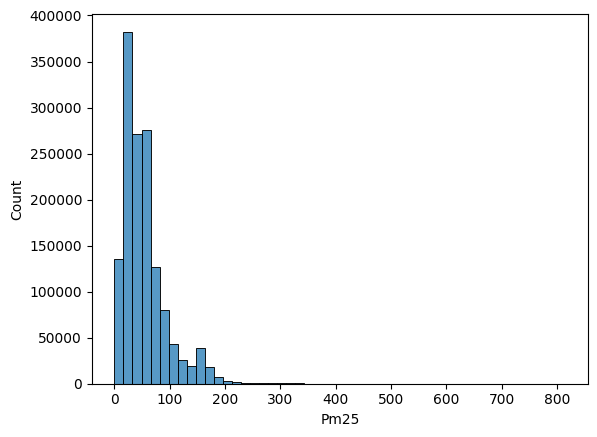

In [15]:
sns.histplot(df["Pm25"], bins=50)

In [16]:
mean_pm25 = df["Pm25"].mean()
median_pm25 = df["Pm25"].median()
skew_pm25 = skew(df["Pm25"].dropna())

print(f"Mittelwert (mean): {mean_pm25:.2f}")
print(f"Median:            {median_pm25:.2f}")
print(f"Schiefe (Skewness): {skew_pm25:.2f}")

Mittelwert (mean): 53.19
Median:            42.00
Schiefe (Skewness): 2.26


### Verteilung der bereinigten PM2.5-Werte

Die PM2.5-Werte zeigen eine deutlich rechtsschiefe Verteilung. Der Mittelwert liegt bei 53,19 µg/m³, während der Median nur 42,00 µg/m³ beträgt. Zusätzlich ergibt die Berechnung der Schiefe (Skewness) einen Wert von 2,26, was auf eine starke Asymmetrie hindeutet.
Diese rechtsschiefe Verteilung bedeutet, dass der Großteil der Messwerte im unteren Bereich liegt, während einige wenige sehr hohe Werte den Mittelwert nach oben ziehen.

Um die Analyse nicht durch technisch bedingte Ausreißer zu verzerren, wurden alle PM2.5-Werte ab 816 µg/m³ ausgeschlossen, da sie deutlich außerhalb des natürlichen Messbereichs liegen und teilweise systematisch auftraten (Platzhalterwerte).

## Kohlenmonoxid (CO)

"Kohlenmonoxid (CO) ist ein farb-, geruch- und geschmackloses Gas, das bei der unvollständigen Verbrennung von Brenn- und Treibstoffen entsteht. Es bildet sich, wenn bei Verbrennungsprozessen zu wenig Sauerstoff zur Verfügung steht. In höheren Konzentrationen wirkt CO als starkes Atemgift." (https://www.umweltbundesamt.de/themen/luft/luftschadstoffe-im-ueberblick/kohlenmonoxid)

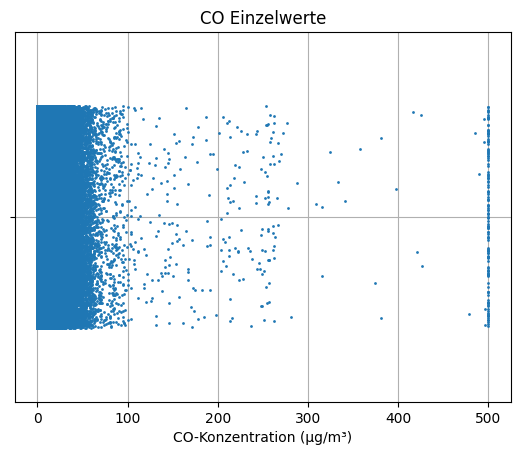

In [17]:
sns.stripplot(x=df["Co"], size=2, jitter=0.3)
plt.title("CO Einzelwerte")
plt.xlabel("CO-Konzentration (µg/m³)")
plt.grid(True);

In [18]:
mean_co = df["Co"].mean()
median_co = df["Co"].median()
skew_co = skew(df["Co"].dropna())

print(f"Mittelwert (mean): {mean_co:.2f}")
print(f"Median:            {median_co:.2f}")
print(f"Schiefe:           {skew_co:.2f}")

Mittelwert (mean): 4.77
Median:            3.40
Schiefe:           27.96


In [19]:
# CO > 300 oder CO == 500 → als NaN
df.loc[df["Co"] >= 300, "Co"] = np.nan

### Verteilung der bereinigten CO-Werte

Die Verteilung der CO-Messwerte ist stark rechtsschief, mit einem Mittelwert von 4.74 µg/m³, einem Median von 3.40 µg/m³ und einer Schiefe von 29.64. Dies deutet auf extreme Ausreißer hin, die den Mittelwert erheblich verzerren. Zusätzlich tritt eine auffällige Häufung exakt bei 500 µg/m³ auf, was sehr wahrscheinlich ein technischer Platzhalterwert ist.

Um die Aussagekraft der Analyse zu erhöhen, wurden daher alle Werte ab 300 µg/m³ ausgeschlossen. Dieser Grenzwert liegt deutlich oberhalb der Hauptverteilung und entfernt technische Ausreißer, aber auch extreme realistische Einzelwerte.

## Stickstoffdioxid (No2)

"Stickstoffdioxid (NO2) ist ein ätzendes Reizgas, es schädigt unmittelbar das Schleimhautgewebe im gesamten Atemtrakt und kann auch die Augen reizen. Stickstoffdioxid zeigt eine stärkere schädliche Wirkung als Stickstoffmonoxid (NO), weshalb Stickstoffdioxid im Zentrum der Bemühungen um saubere Luft steht. [...] Die mittelbare Wirkung des Stickstoffdioxids auf die menschliche Gesundheit besteht in seiner Eigenschaft als Vorläufersubstanz für die Bildung von Feinstaub." (https://www.umweltbundesamt.de/service/uba-fragen/wie-wirken-sich-stickstoffoxide-auf-die-menschliche)

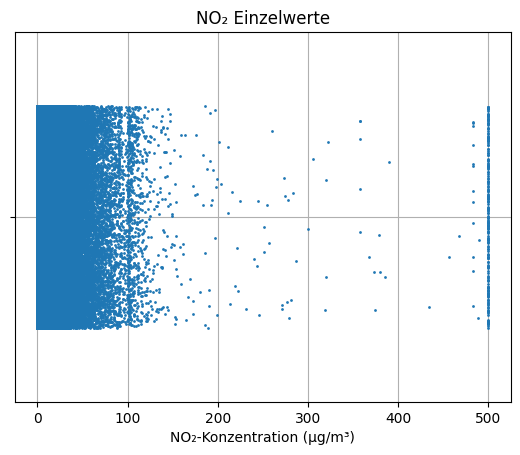

In [20]:
sns.stripplot(x=df["No2"], size=2, jitter=0.3)
plt.title("NO₂ Einzelwerte")
plt.xlabel("NO₂-Konzentration (µg/m³)")
plt.grid(True);

In [21]:
mean_no2 = df["No2"].mean()
median_no2 = df["No2"].median()
skew_no2 = skew(df["No2"].dropna())

print(f"Mittelwert (mean): {mean_no2:.2f}")
print(f"Median:            {median_no2:.2f}")
print(f"Schiefe:           {skew_no2:.2f}")

Mittelwert (mean): 9.76
Median:            7.50
Schiefe:           19.34


In [22]:
# NO2 >= 300 oder == 500
df.loc[df["No2"] >= 300, "No2"] = np.nan

### Bereinigung der NO₂-Werte
Die NO₂-Werte zeigen eine stark rechtsschiefe Verteilung, mit einem Mittelwert von 10.55 µg/m³, einem Median von 8.40 µg/m³ und einer Schiefe von 10.08. Die große Mehrheit der Messwerte liegt unterhalb von 120 µg/m³, während einzelne Ausreißer bis 425 µg/m³ reichen. 

Zusätzlich tritt eine auffällige Häufung bei 500 µg/m³ auf, was sehr wahrscheinlich auf technische Platzhalterwerte zurückzuführen ist.
Um die Analyse nicht durch extreme Einzelwerte zu verzerren, wurden alle NO₂-Werte ab 300 µg/m³ ausgeschlossen.

In [23]:
df["No2"].describe()

count   1,408,527.00
mean            9.67
std             8.29
min             0.00
25%             4.60
50%             7.50
75%            12.40
max           299.80
Name: No2, dtype: float64

## Schwefeldioxid (So2)

"Schwefeldioxid (SO2) ist ein farbloses, stechend riechendes, wasserlösliches Gas, das Mensch und Umwelt beeinträchtigt. In der Atmosphäre aus Schwefeldioxid entstehende Sulfatpartikel tragen zudem zur Belastung mit Feinstaub (PM10) bei." (https://www.umweltbundesamt.de/themen/luft/luftschadstoffe-im-ueberblick/schwefeldioxid)

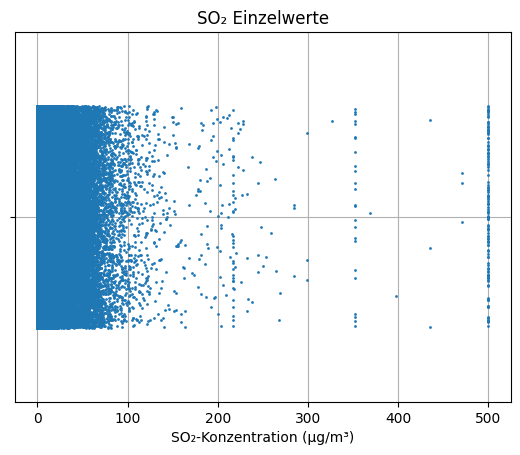

In [24]:
sns.stripplot(x=df["So2"], size=2, jitter=0.3)
plt.title("SO₂ Einzelwerte")
plt.xlabel("SO₂-Konzentration (µg/m³)")
plt.grid(True);

In [25]:
mean_so2 = df["So2"].mean()
median_so2 = df["So2"].median()
skew_so2 = skew(df["So2"].dropna())

print(f"Mittelwert (mean): {mean_so2:.2f}")
print(f"Median:            {median_so2:.2f}")
print(f"Schiefe:           {skew_so2:.2f}")

Mittelwert (mean): 3.98
Median:            2.50
Schiefe:           25.75


Es zeigt sich eine auffällige Punktelinie zwischen 300 und 400, die einen technischen Maximalwert bestimmter Messgeräte vermuten lässt. Wo genau liegt diese Linie?

In [26]:
df["So2"].value_counts().sort_index(ascending=False).head(10)

So2
500.00    125
470.90      3
435.20      3
397.50      1
368.80      1
352.20     24
326.80      1
299.00      3
285.00      3
269.10      1
Name: count, dtype: int64

In [27]:
# SO2 >= 352 oder == 500
df.loc[df["So2"] >= 352, "So2"] = np.nan

### Bereinigung der SO₂-Werte
Die Variable So2 misst die tägliche Schwefeldioxidkonzentration in µg/m³. Die Verteilung ist stark rechtsschief (Skewness = 25.75) mit einem Median von 2.5 µg/m³ und einem Mittelwert von 3.98 µg/m³.

Der Großteil der Werte liegt im Bereich von 0 bis 70 µg/m³, wobei sich oberhalb dieses Bereichs eine kontinuierlich abnehmende Streuung zeigt.

Ab etwa 220 µg/m³ tritt eine leichte Häufung auf, bei 352 µg/m³ eine weitere, und bei 500 µg/m³ zeigt sich eine deutliche Punktelinie – vermutlich ein technischer Maximalwert oder Platzhalter.

Zur Verbesserung der Datenqualität und Modellierbarkeit wurde ein Cutoff bei 352 µg/m³ gesetzt.
Alle Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

## Analyse und Bereinigung der O3-Werte

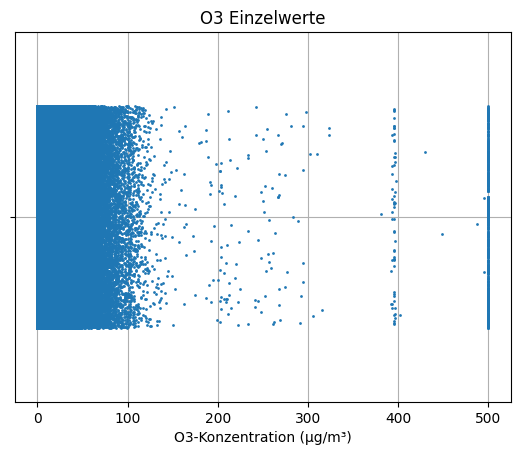

In [28]:
sns.stripplot(x=df["O3"], size=2, jitter=0.3)
plt.title("O3 Einzelwerte")
plt.xlabel("O3-Konzentration (µg/m³)")
plt.grid(True);

In [29]:
mean_o3 = df["O3"].mean()
median_o3 = df["O3"].median()
skew_o3 = skew(df["O3"].dropna())

print(f"Mittelwert (mean): {mean_o3:.2f}")
print(f"Median:            {median_o3:.2f}")
print(f"Schiefe:           {skew_o3:.2f}")

Mittelwert (mean): 20.46
Median:            19.90
Schiefe:           13.71


In [30]:
df["O3"].value_counts().sort_index(ascending=False).head(20)

O3
500.00    536
495.00      1
494.90      1
487.10      1
448.40      1
429.60      1
402.00      1
397.80      1
397.00      1
396.40      8
395.00     36
393.70      9
393.60      1
392.30      2
381.00      1
323.50      2
315.50      1
309.90      1
306.00      1
302.50      1
Name: count, dtype: int64

In [31]:
# O3 >= 323.5 oder == 500
df.loc[df["O3"] >= 323.5, "O3"] = np.nan

### Bereinigung der Ozon-Werte (O₃)
Die Ozonwerte (O3) zeigen eine stark rechtsschiefe Verteilung mit einer Skewness von 13.71. Der Median liegt bei 19.90 µg/m³, der Mittelwert bei 20.46 µg/m³ – was nahe beieinander liegt, aber durch einige hohe Ausreißer leicht verzerrt wird.

Im oberen Bereich der Verteilung ist eine ausgeprägte Punktelinie bei 395 µg/m³ erkennbar, mit 36 identischen Messwerten. Zudem zeigt sich eine große Häufung bei 500 µg/m³ mit 536 Einträgen – ein starkes Indiz für technische Grenzwerte oder Platzhalterwerte.

Zwischen 323.5 µg/m³ und 381 µg/m³ besteht eine auffällige Lücke, was darauf hinweist, dass oberhalb von 323.5 keine kontinuierliche natürliche Streuung mehr vorhanden ist.

→ Es wurde ein Cutoff bei 323.5 µg/m³ gesetzt.
Alle Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

## Analyse und Bereinigung der Pm10-Werte

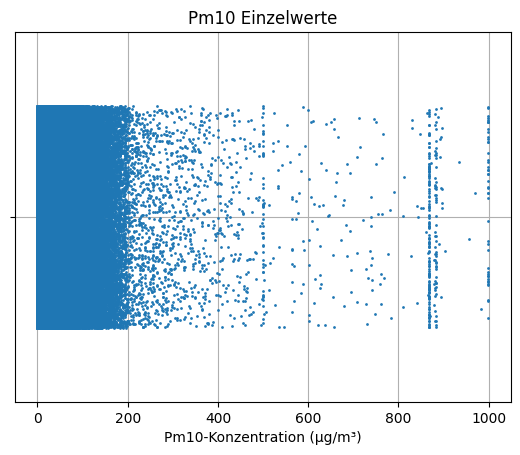

In [32]:
sns.stripplot(x=df["Pm10"], size=2, jitter=0.3)
plt.title("Pm10 Einzelwerte")
plt.xlabel("Pm10-Konzentration (µg/m³)")
plt.grid(True);

In [33]:
df["Pm10"].describe()

count   1,353,189.00
mean           27.07
std            27.69
min             0.00
25%            12.00
50%            19.00
75%            34.00
max           999.00
Name: Pm10, dtype: float64

In [34]:
mean_pm10 = df["Pm10"].mean()
median_pm10 = df["Pm10"].median()
skew_pm10 = skew(df["Pm10"].dropna())

print(f"Mittelwert (mean): {mean_pm10:.2f}")
print(f"Median:            {median_pm10:.2f}")
print(f"Schiefe:           {skew_pm10:.2f}")

Mittelwert (mean): 27.07
Median:            19.00
Schiefe:           9.64


In [35]:
# Wo beginnt die Häufung bei der breiten Linie im Ausreißerbereich (ca. 820-840)?

df["Pm10"].value_counts().loc[lambda x: x.index > 850].sort_index()


Pm10
855.00     1
861.00     1
863.00     1
865.00     1
866.00     1
867.00    59
868.00    72
869.00     1
872.00     1
878.00     1
879.00     2
880.00    20
882.00    24
884.00    13
887.00     1
890.00     1
892.00     1
893.00     1
895.00     4
896.00     4
903.00     1
935.00     1
956.00     1
970.00     1
983.00     1
999.00    45
Name: count, dtype: int64

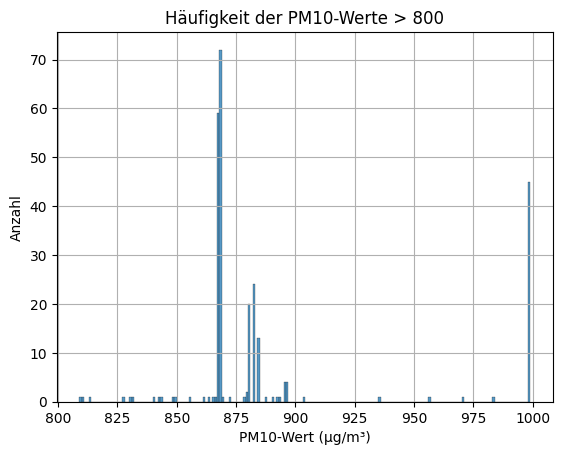

In [36]:
# "Datenmauer" plotten (nicht wirklich nötig, aber "Nice to have" für Leute, die gerne Visualisierungen mögen...)

high_values = df["Pm10"][df["Pm10"] > 800]
sns.histplot(high_values, binwidth=1)
plt.title("Häufigkeit der PM10-Werte > 800")
plt.xlabel("PM10-Wert (µg/m³)")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()


In [37]:
# PM10 >= 867
df.loc[df["Pm10"] >= 867, "Pm10"] = np.nan


### Bereinigung der PM10-Werte
Die PM10-Werte zeigen eine deutlich rechtsschiefe Verteilung mit einem Mittelwert von 32.43 µg/m³, einem Median von 24.00 µg/m³ und einer Schiefe von 7.17. Der größte Teil der Messwerte liegt unterhalb von 200 µg/m³, mit einer kontinuierlich abnehmenden Dichte bis in den Bereich von ca. 850 µg/m³.

Eine detaillierte Analyse der Einzelwertverteilung ergab jedoch eine auffällige Häufung von Messwerten im Bereich 867–882 µg/m³, insbesondere 40 Messungen mit dem identischen Wert 867. Diese systematische Häufung spricht stark für einen technisch bedingten Fehler oder künstlich begrenzte Wertebereiche. Zusätzlich tritt der Platzhalterwert 999 33 Mal auf.

Um die Analyse nicht durch diese systematischen Verzerrungen zu beeinflussen, wurden alle PM10-Werte ab 867 µg/m³ aus dem Datensatz ausgeschlossen.

### Vergleich Anzahl fehlender Werte vor und nach der Ausreißerentfernung

In [38]:
missing_after = df.isna().sum()
outliers_removed = missing_after - missing_before

outlier_table = pd.DataFrame({
    "Missing Before": missing_before,
    "Missing After": missing_after,
    "Outliers Replaced": missing_after - missing_before
})
display(outlier_table)

,Missing Before,Missing After,Outliers Replaced
Year,0,0,0
Month,0,0,0
Day,0,0,0
Country,0,0,0
City,0,0,0
Latitude,2829,2829,0
Longitude,2829,2829,0
Co,631810,631968,158
No2,286260,286514,254
O3,374148,374751,603


In [39]:
# Wieviele Daten (%) wurden durch Ausreißerentfernung verloren?
missing_before_total = missing_before.sum()
missing_after_total = missing_after.sum()
outliers_total = missing_after_total - missing_before_total
outlier_percent = outliers_total / total_values_before * 100

print(f"Anzahl ersetzter Ausreißer: {outliers_total:,}")
print(f"Prozentualer Anteil der ersetzten Ausreißer: {outlier_percent:.4f}%")

Anzahl ersetzter Ausreißer: 1,526
Prozentualer Anteil der ersetzten Ausreißer: 0.0041%


Durch das Entfernen klar identifizierter Ausreißer **in den Schadstoffvariablen** wurden lediglich 0.0041 % der Datenpunkte ersetzt.
Der Datensatz wurde dadurch kaum reduziert, ist aber nun robuster gegenüber Verzerrungen, was insbesondere für Machine-Learning-Modelle, Visualisierungen und Clusteranalysen von Vorteil ist.

# Analyse und Bereinigung der Wettervariablen
Analog zum Vorgehen bei den Schadstoffen werden im Folgenden alle Wettervariablen untersucht und ggf. Platzhalterwerte und starke Ausreißer durch NaN ersetzt.

Anmerkung: Man KÖNNTE auch nur die Platzhalterwerte durch NaN ersetzten und die Ausreißer gesondert kennzeichen. Aber darauf wird jetzt erst einmal verzichtet.

Die Wettervariablen werden in einer Schleife am Stück abgehandelt. Da das Setzen der Grenzwerte und das Entfernen von Ausreißern für jede Variable individuell entscheiden werden sollte, um möglichst alle realistischen Werte zu erhalten, wir dieser Schritt nachgelagert.

In [ ]:
df[["Tavg", "Tmin", "Tmax", "Humidity", "Wspd", "Wdir", "Pres", "Prcp", "Dew"]].describe()


## Auswertung von describe()

| Spalte | Bedingung für NaN                     | Begründung |
|:-------|:--------------------------------------|:-----------|
|Tavg    |                                       |                              |
|Tmin    |                                       |                          |
|Tmax	 |Tmax > 60	                             |weit über weltweit beobachtete Temperaturen|
|Humidity|Humidity < 0 oder > 100                |physikalisch unmöglich / Platzhalter |
|Wspd	 |erst visuell prüfen, dann ggf. > 150   |Hurrikan-Grenze |
|Wdir    |<0 oder >360                           |Windrichtung wird in Winkelgrad gemessen |
|Pres	 |Pres > 1100	                         |ungewöhnlich hoch → Messfehler möglich |
|Prcp	 |nicht filtern, sondern visuell prüfen  |rechtsschiefe, aber plausible Naturverteilung
|Dew	 |ggf. ab –70 prüfen                     |tendenziell realistisch, vorsichtiger Umgang


TD: Eine analoge Tabelle auch für die Schadstoffe anlegen (MK)

# Schleife für Wettervariablen

In [ ]:
weather_columns = ["Tavg", "Tmin", "Tmax", "Humidity", "Wspd", "Wdir", "Pres", "Prcp", "Dew"]

for col in weather_columns:
    print(f"\n📊 Analyse für: {col}")
    
    # Stripplot
    plt.figure(figsize=(10, 2))
    sns.stripplot(x=df[col], size=2, jitter=0.3)
    plt.title(f"{col} – Einzelwerte")
    plt.grid(True)
    plt.xlabel(f"{col}-Wert")
    plt.show()
    
    # Statistische Kennzahlen
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = df[col].skew()
    min_val = df[col].min()
    max_val = df[col].max()
    
    print(f"Mean:   {mean_val:.2f}")
    print(f"Median: {median_val:.2f}")
    print(f"Skew:   {skew_val:.2f}")
    print(f"Min:    {min_val:.2f}")
    print(f"Max:    {max_val:.2f}")
    
    # Cutoff-Vorschlag (nur zur Orientierung)
    cutoff = df[col].quantile(0.999)
    print(f"99.9%-Quantil (suggestion only!): {cutoff:.2f}")


### Cutoffbestimmung und Ausreißerentfernung für Wettervariablen

Für Variablen, bei denen der Stripplot keine eindeutige Auskunft gibt, wird der Cutoff-Wert durch einen Blick auf die betreffenden Messwerte bestimmt:

In [ ]:
# Cutoff für Tmax genauer bestimmen; oberste 10 Messwerte anschauen:
df["Tmax"].value_counts().sort_index(ascending=False).head(10)

# --> Cutoff bei 60 Grad

In [ ]:
df["Dew"].dropna().apply(lambda x: x.is_integer()).value_counts()

In [ ]:
# Tmax: realistische Obergrenze bei 60°C
df.loc[df["Tmax"] > 60, "Tmax"] = np.nan

# Humidity: alles < 0 oder > 100 ist physikalisch nicht (bzw. über 100% nur SEHR kurzzeitig) möglich
df.loc[(df["Humidity"] < 0) | (df["Humidity"] > 100), "Humidity"] = np.nan

# Wspd: Werte > 150 km/h (Orkangrenze) sind extrem selten
df.loc[df["Wspd"] > 150, "Wspd"] = np.nan

# Pres: zwei Ausreißer über 1100 hPa → eher technisches Problem
df.loc[df["Pres"] > 1100, "Pres"] = np.nan

# Prcp: 2 extreme Ausreißer, im prinzip möglich, aber für Modelle ungünstig und für den Gesamtdatensatz nicht repräsentativ
df.loc[df["Prcp"] > 400, "Prcp"] = np.nan

# Dew: Werte von -40 bis 32 sind zu erwarten, und so werden nur wenige Extremwerte entfernt
df.loc[(df["Dew"] < -40) | (df["Dew"] > 32), "Dew"] = np.nan

## Ausführliche Beschreibung der Wettervariablen (sinnvoll?)

🌡️ Tavg – Durchschnittstemperatur

Die Variable Tavg beschreibt die durchschnittliche tägliche Temperatur. Die Verteilung ist leicht linksschief mit einem Skewness-Wert von –0.38. Der Mittelwert beträgt 15.38 °C, der Median liegt bei 15.90 °C, was auf eine weitgehend symmetrische Verteilung mit leichtem Übergewicht kälterer Temperaturen hinweist.

Ein Blick auf den Stripplot zeigt, dass sich alle Werte im realistisch meteorologischen Bereich befinden:

- Das Minimum liegt bei ca. –42 °C, was in sehr kalten Regionen (z. B. in Sibirien oder Teilen Kanadas) durchaus auftreten kann.
- Das Maximum liegt bei ca. 50 °C, was mit bekannten Hitzerekorden weltweit vereinbar ist.

Das 99.9%-Quantil liegt bei 38.30 °C. Dennoch wurde bewusst kein Grenzwert (Cutoff) gesetzt, da keine eindeutig unrealistischen Ausreißer erkennbar sind.

→ Es wurden keine Werte entfernt oder als Ausreißer markiert.

---

🌡️ Tmin – Tagestiefsttemperatur

Die Variable Tmin beschreibt die tägliche Tiefsttemperatur. Die Verteilung zeigt mit einer Schiefe von –0.32 eine leichte Linksschiefe, was auf ein geringfügiges Übergewicht sehr kalter Tage hinweist.
Der Mittelwert beträgt 10.82 °C, der Median 11.00 °C, was auf eine insgesamt symmetrische Verteilung ohne nennenswerte Verzerrungen schließen lässt.

Der Stripplot zeigt eine natürliche, kontinuierliche Verteilung der Messwerte.

- Das Minimum liegt bei –46 °C, was in kalten Klimazonen realistisch ist.
- Das Maximum bei 39 °C ist ungewöhnlich hoch für eine Tiefsttemperatur, aber unter besonderen Bedingungen (z. B. Hitzewellen) möglich.
- Das 99.9%-Quantil liegt bei 32.4 °C, wodurch nur sehr wenige extrem hohe Werte überhaupt betroffen wären.

Insgesamt zeigen sich keine auffälligen Ausreißer oder technische Artefakte.

→ Es wurden keine Werte entfernt oder ersetzt.

---

🌡️ Tmax – Tageshöchsttemperatur

Die Variable Tmax beschreibt die tägliche Höchsttemperatur.
Die Verteilung ist mit einem Skewness-Wert von –0.37 leicht linksschief.
Der Mittelwert beträgt 20.38 °C, der Median liegt bei 21.10 °C – die Verteilung ist insgesamt gut balanciert.

Der Stripplot zeigt einen realistischen Verlauf im Bereich zwischen ca. –37 °C und 50 °C, wobei sich oberhalb von 50 °C vereinzelte Werte häufen. Eine genauere Prüfung der 20 höchsten Werte ergab jedoch drei offensichtliche Ausreißer:
→ 60 °C, 76 °C und 87 °C – allesamt deutlich über bekannten meteorologischen Rekorden.

Als Grenzwert wurde daher ein Cutoff bei 60 °C gesetzt.

→ Drei Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

💧 Humidity – Relative Luftfeuchtigkeit

Die Variable Humidity beschreibt die relative Luftfeuchtigkeit in Prozent.
Die Verteilung ist extrem linksschief mit einer Skewness von –27.84, was auf starke Ausreißer im negativen und sehr hohen Bereich hindeutet.

Die realistischen Messwerte liegen zwischen 0 % und 100 %.
Der Stripplot zeigt jedoch vereinzelte, stark auffällige Werte:

- Das Minimum beträgt –2671.1 %, was physikalisch unmöglich ist
- Das Maximum liegt bei 999.9 %, höchstwahrscheinlich ein Platzhalterwert

→ Es wurde daher ein Grenzbereich von 0 % bis 100 % definiert.
Alle Werte außerhalb dieses Intervalls wurden durch NaN ersetzt.

---

💨 Wspd – Windgeschwindigkeit

Die Variable Wspd beschreibt die tägliche durchschnittliche Windgeschwindigkeit in km/h.
Die Verteilung zeigt eine leichte Rechtsschiefe mit einem Skewness-Wert von 1.51.
Der Mittelwert liegt bei 11.34 km/h, der Median bei 10.00 km/h, was auf einen leicht asymmetrischen, aber plausiblen Verlauf hindeutet.

Der Stripplot zeigt, dass die meisten Messwerte zwischen 0 und 45 km/h liegen, mit ausdünnender Streuung nach oben – was meteorologisch zu erwarten ist.
Drei auffällige Extremwerte oberhalb von 150 km/h wurden identifiziert, der Maximalwert liegt bei 176.3 km/h. Solche Werte sind theoretisch möglich (z. B. bei Orkanen), aber im Kontext dieser Analyse nicht repräsentativ.

→ Es wurde ein Cutoff bei 150 km/h gesetzt.
Drei Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

🌬️ Pres – Luftdruck

Die Variable Pres beschreibt den täglichen Luftdruck in hPa. Die Verteilung ist mit einer Skewness von –0.04 nahezu symmetrisch, was auf eine ausgewogene, realistische Verteilung hinweist.
Der Mittelwert liegt bei 1015.15 hPa, was nahe am physikalischen Normaldruck (1013 hPa) liegt.

Ein Blick auf die Extremwerte zeigt:

- Minimum: 925.2 hPa – plausibel, z. B. bei Tiefdrucklagen
- Maximum: 1392.1 hPa – stark unrealistisch, deutlich über bekannten Rekorden

→ Es wurde ein Cutoff bei 1100 hPa gesetzt.
Zwei klare Ausreißer oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

🌧️ Prcp – Niederschlag

Die Variable Prcp beschreibt die tägliche Niederschlagsmenge in mm. Die Verteilung ist mit einer Skewness von 8.21 stark rechtsschief:

- An über der Hälfte aller Tage wurde kein Niederschlag gemessen (Median: 0.0 mm).
- Einzelne Starkregenereignisse führen zu hohen Maximalwerten (bis zu 462 mm), die jedoch extrem selten sind.

→ Zur Vermeidung einer übermäßigen Verzerrung der Analyse wurde ein Cutoff bei 400 mm gesetzt.
Zwei ungewöhnlich hohe Werte oberhalb dieses Grenzwerts wurden durch NaN ersetzt.

---

💧 Dew – Taupunkt

Die Variable Dew beschreibt den täglichen Taupunkt in °C – also die Temperatur, bei der die Luft mit Wasserdampf gesättigt ist.
Die Werte zeigen eine leicht linksschiefe Verteilung mit einer Skewness von –0.37.
Mittelwert und Median liegen nahe beieinander (9.69 °C bzw. 10.00 °C), was auf eine insgesamt ausgewogene Verteilung hindeutet.

Der Stripplot vermittelt einen „gestückelten“ Eindruck, da etwa zwei Drittel der Werte ganzzahlig sind – vermutlich durch vorverarbeitete oder gerundete Messdaten. Ein gutes Drittel liegt jedoch im nicht-ganzzahligen Bereich, was unterschiedliche Genauigkeitsstufen in den Datenquellen vermuten lässt.

Zur Erkennung potenzieller Ausreißer wurden die physikalisch plausiblen Grenzwerte des Taupunkts berücksichtigt:

- Oberhalb von 32 °C (tropisch-feucht) und
- Unterhalb von –40 °C (polar-trocken) sind reale Messwerte zwar nicht unmöglich, aber extrem selten.

→ Es wurde ein Cutoff bei –40 °C und +32 °C gesetzt. Werte außerhalb dieses Bereichs wurden durch NaN ersetzt.


# Welche Features könnten zusammenhängen (Kollinearität)?

In [ ]:
# Collinearity of features? (heatmap)

# > 0.8 = strong correlation
# 0.5 - 0.8 = moderate correlation
# < 0.5 = weak correlation

# calculate correlation matrix (Pearson)
corr_matrix = df.select_dtypes(include=['number']).corr()

# Display heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature correlations (Pearson)");


In [ ]:
# Show only strong and moderate correlations (>|0.4|); leave out main diagonal (1.0)

# Calculte matrix
corr_matrix = df.select_dtypes(include=['number']).corr()

# extract only strong and moderate correlations (>|0.4|); leave out main diagonal (1.0)
strong_corrs = corr_matrix[(corr_matrix.abs() > 0.4) & (corr_matrix.abs() < 1.0)]

# Convert df to long list (.stack) and reset index
strong_corrs = strong_corrs.stack().reset_index()
strong_corrs.columns = ["Feature 1", "Feature 2", "Korrelation"]

# remove redundant rows (note: the "<"-sign here refers to alphabetic order of feature names, not to numbers of any kind!)
strong_corrs = strong_corrs.loc[strong_corrs["Feature 1"] < strong_corrs["Feature 2"]]

strong_corrs

In [ ]:
# @Wiebke: Der Code hier produziert genau dieselbe Heatmap mit Korrelationen, aber nur die untere Hälfte.
# Ich finde das übersichtlicher, weil die Hälften identisch sind und dadurch komplett redundant
# Wie das geht:
# Duch schreibst eine Maske, die die obere Hälfte der Matrix maskiert (np.triu), np.ones_like erstellt eine Matrix mit den gleichen Dimensionen wie die Korrelationsmatrix
# Das Variable corr_matrix enthält die Daten aus dem df und wurde eine Zelle weiter oben definiert.
# und dtype=bool sorgt dafür, dass die Maske aus True und False besteht
# Dann zeichnest du die Heatmap und übergibst die Maske als Argument


mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature Correlations (Pearson)");


## Analyse der Korrelationen (Pearson) und Vorschläge für weitere Analysen

Die Korrelationsmatrix zeigt mehrere starke und inhaltlich gut erklärbare Zusammenhänge zwischen den numerischen Variablen. Besonders deutlich sind folgende Muster:

**Feinstaub- und Stickstoffdioxidwerte hängen zusammen:**
Es besteht eine starke Korrelation zwischen PM10 und PM2.5 (r = 0.83), was plausibel ist, da PM2.5 eine Teilmenge von PM10 ist. Zusätzlich korreliert NO₂ moderat mit beiden Feinstaubkomponenten (r ≈ 0.42–0.48), was auf gemeinsame Emissionsquellen wie Verkehr oder Industrie hindeutet.

**Temperaturvariablen sind stark untereinander korreliert:**
Die Tagesmitteltemperatur (Tavg) steht in sehr engem Zusammenhang mit Tmin und Tmax (r ≈ 0.97). Auch Tmin und Tmax selbst sind hoch korreliert (r = 0.90). Das ist mathematisch und physikalisch naheliegend und spricht dafür, nicht alle drei Variablen gleichzeitig zu verwenden, um Redundanz zu vermeiden.

**Der Taupunkt (Dew) korreliert stark mit Temperatur:**
Die stärkste Korrelation liegt zwischen Dew und Tmin (r = 0.87), gefolgt von Tavg (r = 0.82). Dies spiegelt wider, dass die Luftfeuchtigkeit – und damit der Taupunkt – eng mit der Umgebungstemperatur zusammenhängt.

**Einige schwächer negative Korrelationen deuten auf atmosphärische Zusammenhänge hin:**
Der Luftdruck (Pres) korreliert moderat negativ mit Dew (r = –0.43) und Tmin (r = –0.42), was mit typischen meteorologischen Prozessen in Zusammenhang stehen kann (z. B. feuchtwarme Luft in Tiefdruckgebieten).

### **Nutzen der Korrelationsanalyse, bzw. Weiterverwendung der Ergebnisse**

Diese Ergebnisse helfen dabei, hoch korrelierte bzw. redundante Variablen zu erkennen und gezielt für weitere Analysen (z. B. Clusteranalyse oder Modellierung) geeignete Features auszuwählen.

Für viele Verfahren, wie z. B. Clustering oder Regressionsmodelle, ist es ratsam, von stark korrelierten Variablen jeweils nur eine zu verwenden, um Verzerrungen oder sogenannte Multikollinearität zu vermeiden.

Alternativ können Hauptkomponentenanalyse (PCA) oder andere dimensionalitätsreduzierende Verfahren genutzt werden, um mehrere stark korrelierte Variablen zu einer gemeinsamen Komponente zusammenzufassen, ohne wesentliche Information zu verlieren.


In [ ]:
df.index

In [ ]:
df.to_csv("data/cleaned_air_quality_data_2025_03_20.csv", index=False)

## Krimskrams

@Wiebke: Aber hier kommt allerlei Zeugs, von dem ich mir nicht sicher bin, ob wie es in der EDA lassen sollen oder auslagern. Es sind verschiedene "Experimente":

In [ ]:
# Plot changes throughout the year. Example: Analyse CO concentration per month

# calculate mean CO per month
monthly_co = df.groupby("Month")["Co"].mean()
# monthly_co = df.groupby("Month")["Co"].mean()

# create plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_co.index, monthly_co.values, marker='o', linestyle='-')
plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Durchschnittliche CO-Konzentration pro Monat")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.grid(True);

# DaAn diesem Schaubild kann man zeigen, dass es Quatsch ist, alle Städte weltweit über einen Kamm zu scheren;
# Es sagt aber an sich nichts Sinnvolles über die Daten aus.

In [ ]:
# Sinnvoller wäre es, die Daten in Nord- und Südhalbkugel zu trennen und getrennt zu betrachten. Aber das ignoriert immer noch viele relevante Faktoren

# Trennung der Daten in Nord- und Südhalbkugel

# Definieren, welche Länder zur Nord- und Südhalbkugel gehören
northern_hemisphere_countries = {
    "US", "CA", "MX", "DE", "FR", "GB", "RU", "CN", "JP", "IN", "IT", "ES", "PL", "TR", "IR", "KR", "UA", "NL", "BE",
    "CH", "SE", "AT", "NO", "FI", "DK", "GR", "CZ", "HU", "RO", "BG", "PT", "IE", "SK", "HR", "LT", "SI", "LV", "EE"
}
southern_hemisphere_countries = {
    "AU", "NZ", "AR", "BR", "ZA", "CL", "ID", "PE", "BO", "EC", "PY", "UY", "MG"
}

# Daten für Nord- und Südhalbkugel filtern
df_north = df[df["Country"].isin(northern_hemisphere_countries)]
df_south = df[df["Country"].isin(southern_hemisphere_countries)]

# Mittlere CO-Konzentration pro Monat berechnen
monthly_co_north = df_north.groupby("Month")["Co"].mean()
monthly_co_south = df_south.groupby("Month")["Co"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

In [ ]:
# CO-Werte über das Jahr inklusive Streuung

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Month", y="Co", errorbar="sd", marker="o")
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist nicht intuitiv aussagekräftig. Die Streuung ist zu stark.

In [ ]:
# Streuung mit Achsenbegrenzung

# Gruppiere nach Monat
grouped = df.groupby("Month")["Co"]
mean = grouped.mean()
std = grouped.std()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(mean.index, mean.values, marker='o', linestyle='-', label='Mittelwert CO')
plt.fill_between(mean.index, mean - std, mean + std, color='blue', alpha=0.2, label='±1 SD')

# Achsen, Titel, Beschriftungen
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Durchschnittliche CO-Konzentration mit Streuung")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])

# Fokus auf relevanten y-Bereich
plt.ylim(3, 7)  # oder anpassen je nach Datensatz

plt.grid(True)
plt.legend()
plt.show()

# Ergebnis: Die Streuung bedeckt die gesamte Diagrammfläche. Es sollten als die Städte, die die größte Verzerrung bewirken, aussortiert werden.


In [ ]:
co_by_city = df.groupby("City")["Co"].mean().sort_values(ascending=False)
print(co_by_city.head(10))

# Ashkelon ist ein unrealistischer Ausreißer. Siehe separates NB "Ashkelon": Es gibt nur Messwerte für Jan und Feb 2022, und diese schwanken extrem. Vielleicht kaputtes Messgerät.

In [ ]:
# calculate std per city

co_std_by_city = df.groupby("City")["Co"].std().sort_values(ascending=False)
print(co_std_by_city.head(10))

In [ ]:
# combine mean and std to determine cities that cause the bigges distortions.

co_stats = df.groupby("City")["Co"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
print(co_stats.head(10))

In [ ]:
# The three Israeli cities of Ashkelon, Ashdod and Netanya show highly volatile CO values, measured only in certain months.
# This distorts the graph to an extent that calls for dropping these three cities from further analyes of CO.

In [ ]:
# Drop distorting cities from fürther analyses
exclude_cities = ["Ashkelon", "Ashdod", "Netanya"]
df_cleaned = df[~df["City"].isin(exclude_cities)]

In [ ]:
# Streuung mit Achsenbegrenzung, ohne Ausreißerstädte in Israel

# Gruppiere nach Monat
grouped = df_cleaned.groupby("Month")["Co"]
mean = grouped.mean()
std = grouped.std()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(mean.index, mean.values, marker='o', linestyle='-', label='Mittelwert CO')
plt.fill_between(mean.index, mean - std, mean + std, color='blue', alpha=0.2, label='±1 SD')

# Achsen, Titel, Beschriftungen
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Durchschnittliche CO-Konzentration mit Streuung")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])

# Fokus auf relevanten y-Bereich
plt.ylim(3, 7)  # oder anpassen je nach Datensatz

plt.grid(True)
plt.legend()
plt.show()

# Ergebnis: Die Streuung bedeckt die gesamte Diagrammfläche. Es sollten als die Städte, die die größte Verzerrung bewirken, aussortiert werden.


In [ ]:
# CO-Werte über das Jahr inklusive Streuung

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned, x="Month", y="Co", errorbar="sd", marker="o")
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist immer noch nicht nicht intuitiv aussagekräftig. Die Streuung ist weiterhin zu stark.

In [ ]:
# Ursachenforschung für die starke CO-Streuung

co_std_cleaned = df_cleaned.groupby("City")["Co"].std().sort_values(ascending=False)
print(co_std_cleaned.head(10))

In [ ]:
co_stats_cleaned = df_cleaned.groupby("City")["Co"].agg(["mean", "std"]).sort_values(by="std", ascending=False)
print(co_stats_cleaned.head(10))

In [ ]:
# Weitere Städte mit extremer Varianz entfernen, um eine übersichtliche globale Darstellung zu erzielen

more_extreme = ["Portland", "Mérida", "Zamboanga", "Butuan", "Hạ long", "Oaxaca", "Isfahan", "San luis potosí", "Tabriz", "Tallahassee"]
exclude_cities = ["Ashkelon", "Ashdod", "Netanya"] + more_extreme
df_cleaned2 = df[~df["City"].isin(exclude_cities)]

In [ ]:
# CO-Werte über das Jahr inklusive Streuung, weiter reduziert

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned2, x="Month", y="Co", marker="o")
plt.fill_between(mean.index, mean - std * 0.5, mean + std * 0.5, alpha=0.2, label='±0.5 SD')
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist immer noch nicht nicht intuitiv aussagekräftig. Die Streuung ist weiterhin zu stark.

In [ ]:

# Nord- und Südhalbkugel anhand des Features "Latitude" trennen

df_cleaned2.loc[:, "Hemisphere"] = df_cleaned2.loc[:, "Latitude"].apply(lambda x: "Nordhalbkugel" if x >= 0 else "Südhalbkugel")



In [ ]:
df_north = df_cleaned2[df_cleaned2["Hemisphere"] == "Nordhalbkugel"]
df_south = df_cleaned2[df_cleaned2["Hemisphere"] == "Südhalbkugel"]

In [ ]:
# Nordhalbkugel
grouped_north = df_north.groupby("Month")["Co"]
mean_north = grouped_north.mean()
std_north = grouped_north.std()

# Südhalbkugel
grouped_south = df_south.groupby("Month")["Co"]
mean_south = grouped_south.mean()
std_south = grouped_south.std()

# Plot
plt.figure(figsize=(10, 5))

plt.plot(mean_north.index, mean_north, marker='o', label="Nordhalbkugel")
plt.fill_between(mean_north.index, mean_north - std_north, mean_north + std_north, alpha=0.2)

plt.plot(mean_south.index, mean_south, marker='s', label="Südhalbkugel")
plt.fill_between(mean_south.index, mean_south - std_south, mean_south + std_south, alpha=0.2)

plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Saisonale CO-Muster nach Hemisphäre")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Mittlere CO-Konzentration pro Monat berechnen
monthly_co_north = df_north.groupby("Month")["Co"].mean()
monthly_co_south = df_south.groupby("Month")["Co"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

In [ ]:
# Mittlere CO-Konzentration pro Monat berechnen- Median statt Mean, weil robuster gegen Ausreißer
monthly_co_north = df_north.groupby("Month")["Co"].median()
monthly_co_south = df_south.groupby("Month")["Co"].median()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

In [ ]:
# sns.histplot(df_north["Co"], kde=True)
# sns.histplot(df_south["Co"], kde=True)

plt.figure(figsize=(10, 5))

# Nordhalbkugel
sns.histplot(df_north["Co"], kde=True, label="Nordhalbkugel", stat="density", element="step", fill=True)

# Südhalbkugel
sns.histplot(df_south["Co"], kde=True, label="Südhalbkugel", stat="density", element="step", fill=True)

# Achsen & Legende
plt.xlabel("CO-Konzentration (ppm)")
plt.ylabel("Dichte")
plt.title("Verteilung der CO-Werte nach Hemisphäre")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))

# Histogramm Nordhalbkugel
sns.histplot(df_north["Co"], kde=True, stat="density", label="Nordhalbkugel", color="steelblue", fill=True)

# Histogramm Südhalbkugel
sns.histplot(df_south["Co"], kde=True, stat="density", label="Südhalbkugel", color="darkorange", fill=True)

# Zoom auf interessanten Bereich
plt.xlim(0, 20)    # X-Achse (CO-Werte) begrenzen
plt.ylim(0, 0.7)   # Y-Achse (Dichte) begrenzen

# Titel & Achsen
plt.xlabel("CO-Konzentration (ppm)")
plt.ylabel("Dichte")
plt.title("CO-Verteilung nach Hemisphäre (vergrößerter Bereich)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Mittlere CO-Konzentration pro Land berechnen
country_co_avg = df.groupby("Country")["Co"].mean().sort_values(ascending=False)

# Barplot erstellen
plt.figure(figsize=(12, 6))
country_co_avg.plot(kind='bar', color='b', alpha=0.7)
plt.xlabel("Land")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Durchschnittliche CO-Konzentration pro Land")
plt.xticks(rotation=90)  # Länderbeschriftung drehen für bessere Lesbarkeit
plt.grid(axis='y', linestyle='--', alpha=0.7);


In [ ]:
# Mittlere CO-Konzentration pro Land berechnen

# Mindestanzahl an CO-Messwerten pro Land, um in die Analyse aufgenommen zu werden
min_measurements = 100  # Falls nötig, anpassen

# Anzahl der CO-Messwerte pro Land berechnen
country_co_counts = df.groupby("Country")["Co"].count()

# Nur Länder behalten, die mindestens `min_measurements` Messwerte haben
valid_countries = country_co_counts[country_co_counts >= min_measurements].index

# Gefilterten DataFrame mit diesen Ländern erstellen
df_valid_countries = df[df["Country"].isin(valid_countries)]

# Mittlere CO-Konzentration für diese Länder berechnen
country_co_avg_filtered = df_valid_countries.groupby("Country")["Co"].mean().sort_values(ascending=False)

# Falls nach der Filterung noch Daten vorhanden sind, Plot erstellen
if not country_co_avg_filtered.empty:
    plt.figure(figsize=(12, 6))
    country_co_avg_filtered.plot(kind='bar', color='b', alpha=0.7)
    plt.xlabel("Land")
    plt.ylabel("Mittlere CO-Konzentration")
    plt.title("Durchschnittliche CO-Konzentration pro Land (nur Länder mit ausreichenden Messwerten)")
    plt.xticks(rotation=90)  # Länderbeschriftung drehen für bessere Lesbarkeit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    print("Keine ausreichenden Daten für CO-Werte in den Ländern verfügbar.")


In [ ]:
country_co_avg_filtered.head(20).plot(kind='bar')


In [ ]:
# Vergleich von Schadstoffen in verschiedenen Städten

# Liste der relevanten Schadstoff-Spalten (falls sie in den Daten vorhanden sind)
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_pollutants = df[pollutants].dropna()

# Korrelationsmatrix berechnen
corr_matrix = df_pollutants.corr()

# Heatmap der Korrelationen erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen CO und anderen Schadstoffen");


In [ ]:
df[["Co", "No2"]].corr()

In [ ]:
# Ab hier Variablen korrigieren!!!

# # Korrelation Schadstoffe und Wettervariablen

# # Liste der Schadstoffe und Wettervariablen
# pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]
# weather_vars = ["temperature", "pressure", "humidity", "dew", "wind-speed", "wind-gust"]

# # DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
# df_pollutants_weather = df[pollutants + weather_vars].dropna()

# # Korrelationsmatrix berechnen
# corr_matrix_weather = df_pollutants_weather.corr()

# # Heatmap der Korrelationen zwischen Schadstoffen & Wettervariablen
# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_matrix_weather, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
# plt.title("Korrelation zwischen Schadstoffen und Wetterfaktoren");

In [ ]:
df[["co", "temperature"]].corr()

In [ ]:
# Schadstoffbelastung über die Zeit in verschiedenen Städten

# Durchschnittliche Schadstoffwerte pro Jahr berechnen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]
yearly_trends = df.groupby("Year")[pollutants].mean()

# Liniendiagramm für langfristige Trends erstellen
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(yearly_trends.index, yearly_trends[pollutant], marker='o', linestyle='-', label=pollutant)

plt.xlabel("Jahr")
plt.ylabel("Mittlere Konzentration")
plt.title("Langfristige Entwicklung der Schadstoffwerte")
plt.legend()
plt.grid(True);


In [ ]:
# Ohne 2014 und 2025, weil zu wenige Daten

# Schadstoffe, die analysiert werden sollen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["Year"], errors="coerce")

# Durchschnittliche Schadstoffwerte pro Jahr berechnen, aber 2014 & 2025 ausschließen
yearly_trends = df.groupby("Year")[pollutants].mean()
yearly_trends = yearly_trends.loc[(yearly_trends.index > 2014) & (yearly_trends.index < 2025)]

# Liniendiagramm für langfristige Trends erstellen
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(yearly_trends.index, yearly_trends[pollutant], marker='o', linestyle='-', label=pollutant)

plt.xlabel("Jahr")
plt.ylabel("Mittlere Konzentration")
plt.title("Langfristige Entwicklung der Schadstoffwerte (ohne 2014 & 2025)")
plt.legend()
plt.grid(True);


In [ ]:
num_cities_with_data = df.loc[:, ["City", "Co", "No2", "So2", "O3", "Pm25", "Pm10"]].dropna(subset=["Co", "No2", "So2", "O3", "Pm25", "Pm10"], how="all")["City"].nunique()
print(f"Anzahl der Städte mit mindestens einem Messwert: {num_cities_with_data}")

In [ ]:
    import matplotlib.pyplot as plt

    # Schadstoffe, die analysiert werden sollen
    pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

    # Länder nach Regionen gruppieren
    regions = {
        "Europe": {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"},
        "North America": {"US", "CA", "MX"},
        "South America": {"BR", "AR", "CO", "CL", "PE"},
        "Asia": {"CN", "IN", "JP", "KR", "IR"},
        "Africa": {"ZA", "EG", "NG"},
        "Oceania": {"AU", "NZ"}
    }

    # Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    # Regionen durchgehen & Diagramme erstellen
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)  # Einheitliche Achsen für bessere Vergleichbarkeit
    axes = axes.flatten()  # 2D-Array in 1D-Array umwandeln

    # Speichert alle Linien für die gemeinsame Legende
    handles, labels = [], []

    for i, (region, countries) in enumerate(regions.items()):
        df_region = df[df["Country"].isin(countries)]
        yearly_trends_region = df_region.groupby("Year")[pollutants].mean()
        yearly_trends_region = yearly_trends_region.loc[(yearly_trends_region.index > 2014) & (yearly_trends_region.index < 2025)]
        
        ax = axes[i]
        for pollutant in pollutants:
            line, = ax.plot(yearly_trends_region.index, yearly_trends_region[pollutant], marker='o', linestyle='-', label=pollutant)
            
            # Speichert eine Linie pro Schadstoff für die gemeinsame Legende
            if i == 0:  
                handles.append(line)
                labels.append(pollutant)

        ax.set_title(region)
        ax.set_xlabel("Jahr")
        ax.set_ylabel("Mittelwert")
        ax.grid(True)

    for ax in axes[:3]:  # Die ersten drei Subplots sind in der oberen Reihe
        ax.xaxis.set_tick_params(labelbottom=True)

    # Gemeinsame Legende unterhalb der Subplots platzieren
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(pollutants))

    # Layout optimieren
    plt.tight_layout();

In [ ]:
# Sechs Top-Länder in Europa

import matplotlib.pyplot as plt

# Schadstoffe, die analysiert werden sollen
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Europäische Länder definieren
european_countries = {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"}

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Nur europäische Länder auswählen
df_europe = df[df["Country"].isin(european_countries)]

# Länder mit den meisten Messwerten identifizieren
top_countries = df_europe["Country"].value_counts().nlargest(6).index  # Falls nur 6 Länder visualisiert werden sollen

# Subplots für die gewählten Länder erstellen
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)  # 2 Reihen, 3 Spalten
axes = axes.flatten()

for i, country in enumerate(top_countries):
    df_country = df_europe[df_europe["Country"] == country]
    yearly_trends_country = df_country.groupby("year")[pollutants].mean()
    yearly_trends_country = yearly_trends_country.loc[(yearly_trends_country.index > 2014) & (yearly_trends_country.index < 2025)]
    
    ax = axes[i]
    for pollutant in pollutants:
        ax.plot(yearly_trends_country.index, yearly_trends_country[pollutant], marker='o', linestyle='-', label=pollutant)
    
    ax.set_title(country)
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Mittelwert")
    ax.grid(True)

# Gemeinsame Legende unterhalb der Subplots platzieren
fig.legend(pollutants, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(pollutants))

# Layout optimieren
plt.tight_layout();

In [ ]:
# Korrekation zwischen Ozon und anderen Faktoren

# Relevante Spalten auswählen
pollutants = ["co", "no2", "so2", "pm10", "pm25", "o3"]
weather_vars = ["temperature", "pressure", "humidity", "dew", "wind-speed", "wind-gust"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_ozone_corr = df[pollutants + weather_vars].dropna()

# Korrelationsmatrix berechnen
corr_matrix_ozone = df_ozone_corr.corr()

# Heatmap der Korrelationen zwischen Ozon und anderen Faktoren
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_ozone, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen Ozon (O₃) und anderen Faktoren");


In [ ]:
# Durchschnittliche Ozonwerte pro Monat berechnen
monthly_o3 = df.groupby("month")["o3"].mean()

# Liniendiagramm für die saisonale Entwicklung von Ozon erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_o3.index, monthly_o3.values, marker='o', linestyle='-', color='b')
plt.xlabel("Monat")
plt.ylabel("Mittlere O₃-Konzentration")
plt.title("Saisonale Entwicklung der Ozonwerte (O₃)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.grid(True);

In [ ]:
# Länder nach Hemisphäre aufteilen
northern_hemisphere_countries = {
    "US", "CA", "MX", "DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE", "RU", "CN", "JP", "IN", "KR"
}
southern_hemisphere_countries = {
    "AU", "NZ", "AR", "BR", "ZA", "CL", "ID", "PE", "BO", "EC", "PY", "UY", "MG"
}

# Daten für Nord- und Südhalbkugel filtern
df_north = df[df["Country"].isin(northern_hemisphere_countries)]
df_south = df[df["Country"].isin(southern_hemisphere_countries)]

# Durchschnittliche Ozonwerte pro Monat für beide Hemisphären berechnen
monthly_o3_north = df_north.groupby("month")["o3"].mean()
monthly_o3_south = df_south.groupby("month")["o3"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_o3_north.index, monthly_o3_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_o3_south.index, monthly_o3_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere O₃-Konzentration")
plt.title("Vergleich der Ozonwerte (O₃) zwischen Nord- und Südhalbkugel")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.legend()
plt.grid(True);



In [ ]:
import matplotlib.pyplot as plt

# Europäische Länder definieren
european_countries = {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"}

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Nur europäische Länder auswählen
df_europe = df[df["Country"].isin(european_countries)]

# Jahre 2014 & 2025 aus der Analyse entfernen
df_europe = df_europe[(df_europe["year"] > 2014) & (df_europe["year"] < 2025)]

# Nur Länder behalten, die tatsächlich O₃-Werte haben
countries_with_o3 = df_europe.groupby("Country")["o3"].count()
valid_countries = countries_with_o3[countries_with_o3 > 0].index  # Länder mit vorhandenen O₃-Werten

# DataFrame auf diese Länder filtern
df_europe = df_europe[df_europe["Country"].isin(valid_countries)]

# Standardabweichung (Schwankungsstärke) von O₃ pro Jahr & Land berechnen
ozone_volatility = df_europe.groupby(["year", "Country"])["o3"].std().unstack()

# Diagramm erstellen
fig, ax = plt.subplots(figsize=(12, 6))
handles = []  # Zum Speichern der Linien für die Legende
labels = []   # Zum Speichern der Ländernamen

for country in ozone_volatility.columns:
    line, = ax.plot(ozone_volatility.index, ozone_volatility[country], marker='o', linestyle='-', label=country)
    handles.append(line)
    labels.append(country)

ax.set_xlabel("Jahr")
ax.set_ylabel("Standardabweichung von O₃ (Schwankungsstärke)")
ax.set_title("Jährliche Schwankungsstärke der Ozonwerte in europäischen Ländern (nur Länder mit Daten)")
ax.grid(True)

# Legende unterhalb des Plots platzieren
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(valid_countries))

# Layout optimieren
plt.tight_layout();